In [1]:
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_from_disk
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config_path = "C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/wikiart_classification/models_history/resnet50_finetune/best_config.json"
model_path = "C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/wikiart_classification/models_history/resnet50_finetune/best_resnet50_finetune_multihhead.pth"

with open(config_path, "r") as f:
    best_config = json.load(f)

dataset_path = "C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/bob/data/mywikiart"
dataset = load_from_disk(dataset_path)
print("Remapped dataset loaded from disk")
print(f"Dataset size: {len(dataset)} images.")


Remapped dataset loaded from disk
Dataset size: 5119 images.


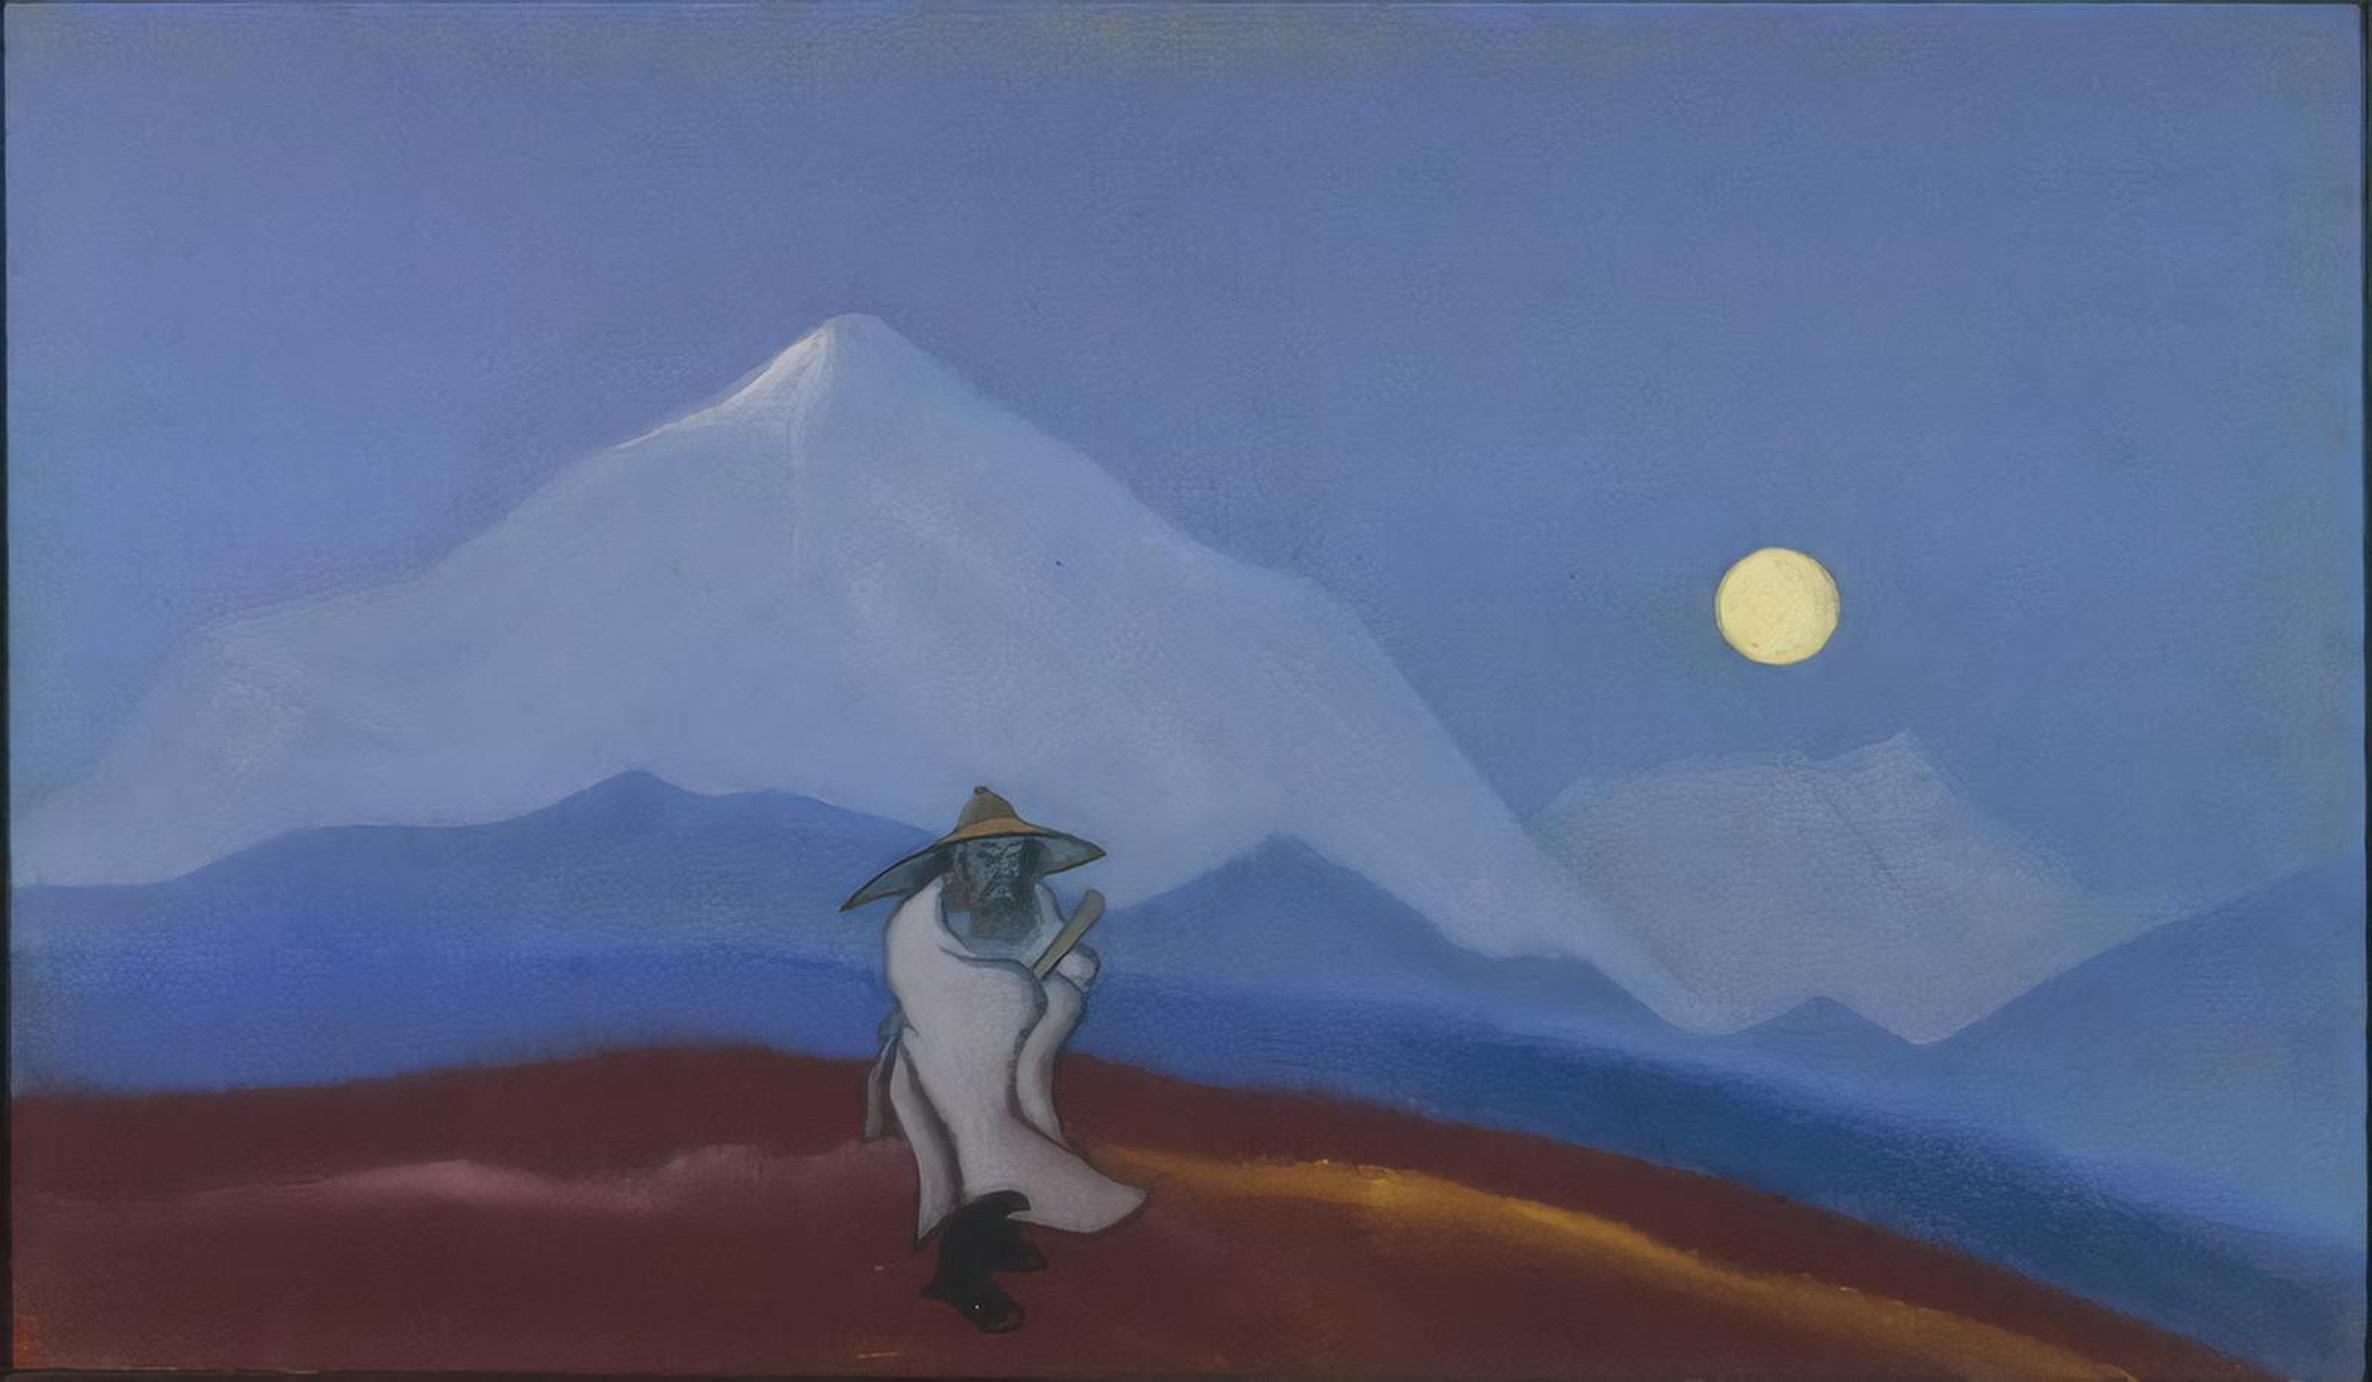

In [5]:
display(dataset[450]["image"])

In [1]:


class ResNet50FineTuneMultiHead(nn.Module):
    def __init__(self, num_genres, num_styles, dropout_rate=0.0):
        super(ResNet50FineTuneMultiHead, self).__init__()
        # Load pretrained ResNet50.
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        # Freeze all layers.
        for param in self.resnet.parameters():
            param.requires_grad = False
        # Unfreeze the last 4 children modules.
        children = list(self.resnet.children())
        for child in children[-4:]:
            for param in child.parameters():
                param.requires_grad = True
        # Replace the final fully connected layer with an Identity to extract features.
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        # Define new classifier heads with dropout.
        self.genre_classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_genres)
        )
        self.style_classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_styles)
        )
        
    def forward(self, x):
        features = self.resnet(x)
        genre_logits = self.genre_classifier(features)
        style_logits = self.style_classifier(features)
        return genre_logits, style_logits

num_genres = len(set(dataset["genre"]))
num_styles = len(set(dataset["style"]))
print(f"Number of genre classes: {num_genres}")
print(f"Number of style classes: {num_styles}")

model = ResNet50FineTuneMultiHead(num_genres, num_styles, dropout_rate=best_config["dropout_rate"]).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

inference_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


Remapped dataset loaded from disk
Dataset size: 17061 images.
Train dataset size: 11942 images
Validation dataset size: 1706 images
Test dataset size: 3413 images
Number of genre classes: 11
Number of style classes: 11


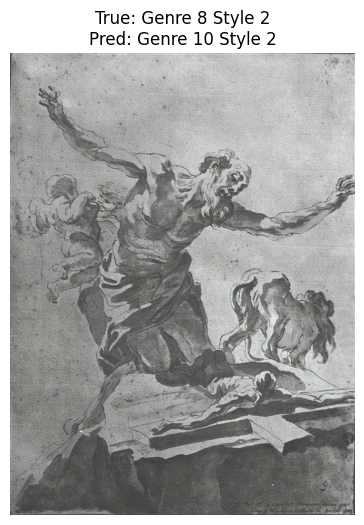

In [2]:
sample = random.choice(test_dataset)
gt_genre = sample["genre"]
gt_style = sample["style"]
img = inference_transforms(sample["image"]).unsqueeze(0).to(device)
with torch.no_grad():
    genre_logits, style_logits = model(img)
    predicted_genre = torch.argmax(genre_logits, dim=1).item()
    predicted_style = torch.argmax(style_logits, dim=1).item()

plt.figure(figsize=(6,6))
plt.imshow(sample["image"])
plt.axis("off")
plt.title(f"True: Genre {gt_genre} Style {gt_style}\nPred: Genre {predicted_genre} Style {predicted_style}")
plt.show()